In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb


In [1]:
import pickle as pk

In [4]:
mat = './GSE272271_D45matrix/D45matrix/filtered_feature_bc_matrix/matrixD45.mtx/fileset'
adata = sc.read_10x_mtx(mat)

/home/saigum/anaconda3/envs/singleseq/lib/python3.12/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


69,123 genes , 24,185 cells

In [5]:
adata = sc.read(mat)
adata.X=adata.X.toarray()
adata = adata.transpose()

In [6]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
adata.obs['n_counts'] = adata.X.sum(1)

In [10]:
adata.obs['n_genes'] = (adata.X>0).sum(1)

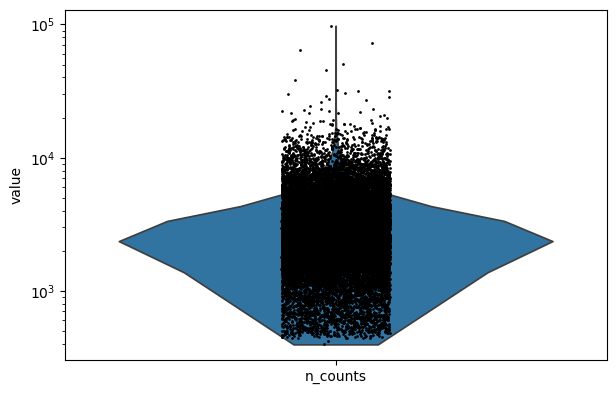

In [17]:
t1 = sc.pl.violin(adata,'n_counts' ,size=2,log=True,cut=0)

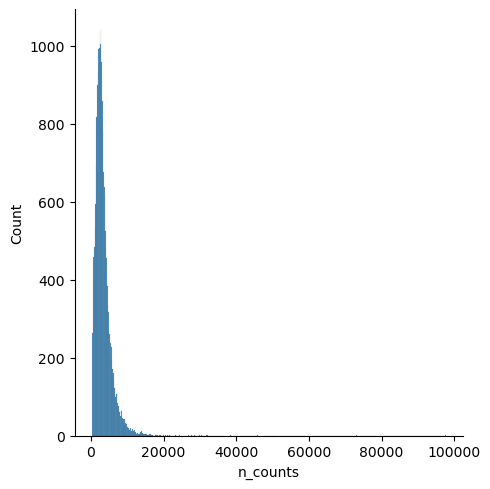

In [11]:
p1 = sb.displot(adata.obs['n_counts'],kde=False)
plt.show()

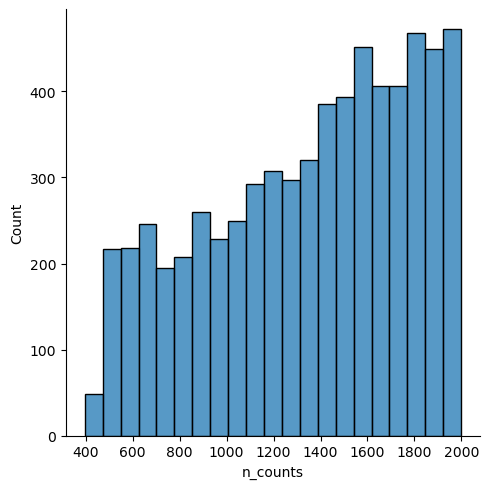

In [19]:
p3 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']<2000])

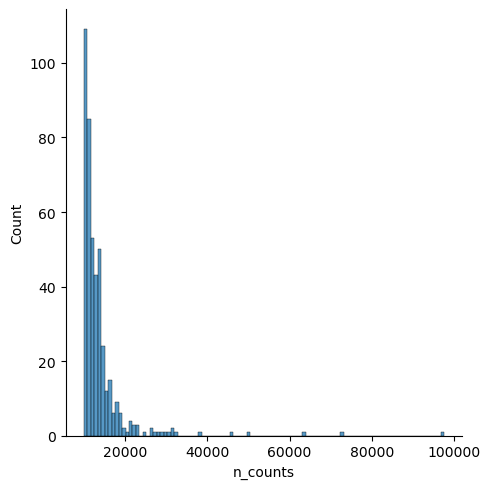

In [20]:
p2 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']>10000])

In [6]:
adata.var["hb"]  = adata.var_names.str.contains(("^HB[^(P)]"))
adata.var["mt"]  = adata.var_names.str.contains("^MT-")
adata.var['rb']  = adata.var_names.str.contains("^RPS|^RPL")

In [17]:
np.mean(adata.var['mt'])

0.0005352776933871504

In [7]:
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt", "rb", "hb"],inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 24185 × 69123
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'hb', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [8]:
from scipy.stats import median_abs_deviation

In [9]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [10]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    23359
True       826
Name: count, dtype: int64

In [11]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    21719
True      2466
Name: count, dtype: int64

In [12]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 24185
Number of cells after filtering of low quality cells: 21380


In [1]:
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)




NameError: name 'sc' is not defined

In [42]:
import logging

In [2]:
from rpy2.robjects import  pandas2ri
import anndata2ri

In [3]:
import rpy2

In [4]:

%load_ext rpy2.ipython

In [29]:
import rpy2

In [17]:
adata_pp = adata.copy()

In [18]:
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)


In [19]:
sc.tl.leiden(adata_pp,key_added='groups')

/tmp/ipykernel_293239/413044154.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp,key_added='groups')


In [20]:
data_mat  = adata_pp.X.T

In [21]:
input_groups = adata_pp.obs['groups']

In [ ]:
%%R 
library(scran)

In [23]:
from  scipy.sparse import issparse

In [24]:
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()

In [25]:
adata_pp.obs["groups"]

AAACCTGCATCATCCC-1     4
AAACCTGGTCTCCATC-1    10
AAACCTGGTGAGGCTA-1     3
AAACCTGGTTAGAACA-1     9
AAACCTGGTTTGACTG-1     6
                      ..
TTTGGTTCATAAGACA-6     0
TTTGGTTCATGTCCTC-6     0
TTTGGTTGTCTTGATG-6     4
TTTGTCAAGATGCGAC-6     1
TTTGTCAAGTGTCCCG-6     0
Name: groups, Length: 21380, dtype: category
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']

In [26]:
import rpy2.robjects
import anndata2ri
from rpy2.robjects import pandas2ri

anndata2ri.activate()
pandas2ri.activate()

rpy2.robjects.globalenv['data_mat'] = data_mat
rpy2.robjects.globalenv['input_groups'] = adata_pp.obs["groups"]

/tmp/ipykernel_293239/4024937474.py:5: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [38]:
%%R
R.version.string

[1] "R version 4.4.1 (2024-06-14)"


In [27]:
from scipy.sparse import csr_matrix

In [28]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1
    )
)

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [29]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [30]:
adata.layers['scran_normalization']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 34500967 stored elements and shape (21380, 69123)>

In [31]:
with open("normalized_adata.pickle", "wb") as adata_normal:
    pk.dump(adata, adata_normal)

In [32]:
import seaborn as sns

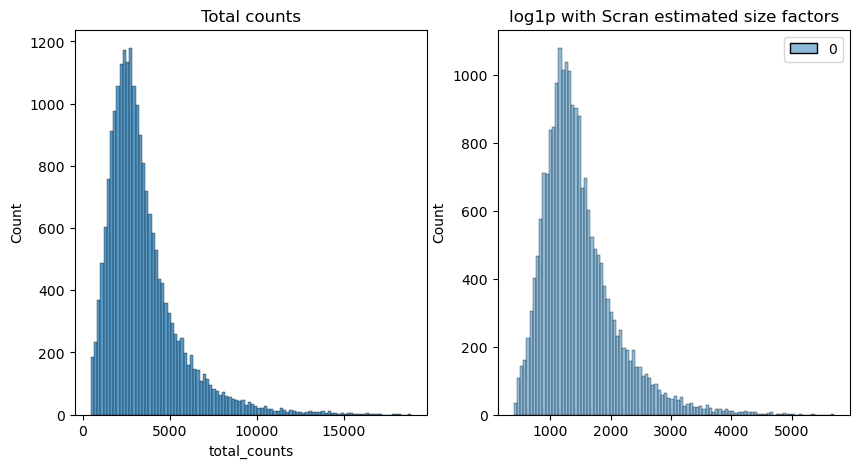

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

In [35]:
%%R
library(scry)

In [36]:
rpy2.robjects.globalenv['adata'] = adata

In [37]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

: 

In [ ]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [36]:
adata.var['highly_variable'] = sc.pp.highly_variable_genes(adata)

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 34500967 stored elements and shape (21380, 69123)>

In [ ]:
### to find optimal number of pca components

In [33]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(adata.X)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [37]:
from scipy.sparse import csr_matrix

In [38]:
### Pearson normalization
analytic_pearson =  adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [ ]:
c.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [30]:
%%R
library(scry)

UsageError: Cell magic `%%R` not found.


In [51]:
sc.pp.neighbors(adata, n_pcs=30)


/home/saigum/anaconda3/envs/singleseq/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 69123 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [52]:
sc.tl.umap(adata)

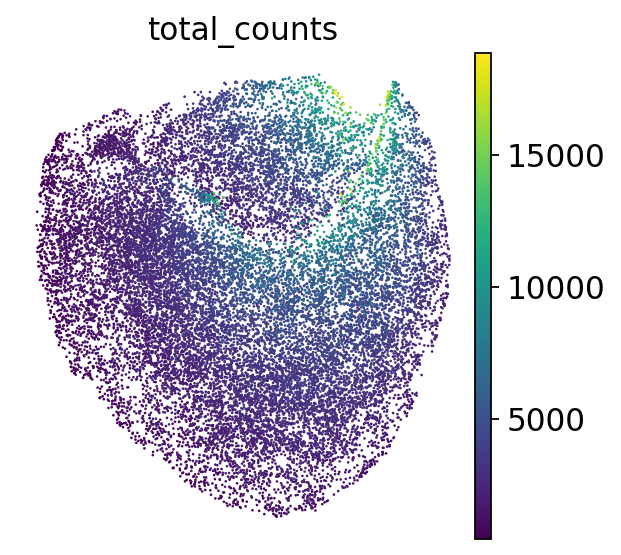

In [53]:
sc.pl.umap(adata, color="total_counts")

In [54]:
sc.tl.tsne(adata)

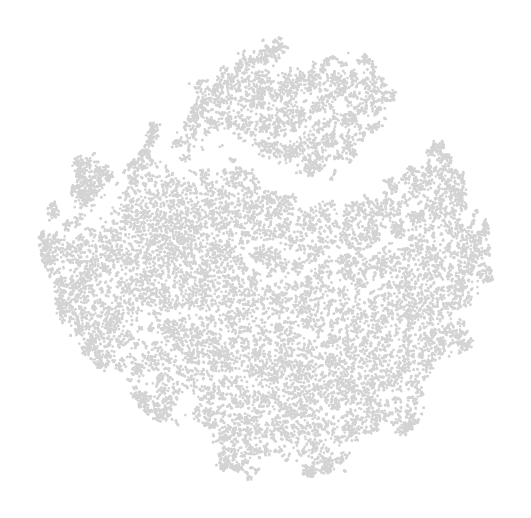

In [55]:
sc.pl.tsne(adata)

In [56]:
sc.tl.louvain(adata)

In [58]:
sc.pl.clustermap(adata)

/home/saigum/anaconda3/envs/singleseq/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


: 

In [31]:
adata.X.shape

(21380, 69123)

In [ ]:
sum(rb_gene_mask)

1128

In [62]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/tmp/ipykernel_223770/3659631106.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [33]:
adata

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [64]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [65]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

: 

In [1]:
adata

NameError: name 'adata' is not defined

In [ ]:
################ non  working shit

In [22]:
adata.obs['MT_frac'] =  adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

In [33]:
adata.var['MT'] = mt_gene_mask

In [35]:
adata.var['MT']

37

In [26]:
adata.var_names.str.startswith(("RPS", "RPL"))

array([False, False, False, ..., False, False, False])

In [ ]:
adata

In [27]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))


Total number of cells: 24185


: 

In [ ]:

adata = adata[adata.obs['MT_frac']<0.2]
print('Number of cells after mt count filter: {:d}'.format(adata.n_obs))


Number of cells after mt count filter: 22570


In [ ]:
np.array(adata.X)

In [ ]:
adata.var = adata.var.drop(columns='data_type')

In [ ]:
sc.pp.filter_genes(adata,min_cells=10)

In [ ]:
sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

Number of cells after mt count filter: 22570


In [ ]:
adata.X.shape

: 

In [ ]:
np.mean(adata.obs['n_genes']) - 2*np.sqrt(np.var(adata.obs['n_genes']))

In [ ]:
adata_pp = adata.copy()

In [ ]:
sc.pp.normalize_total(adata_pp)

NameError: name 'sc' is not defined

In [ ]:
sc.pp.log1p(adata_pp)

In [ ]:
sc.pp.pca(adata_pp,n_comps=15)

In [ ]:
sc.pp.neighbors(adata_pp)

In [ ]:
sc.tl.leiden(adata_pp,key_added='groups')

In [ ]:
data_mat = adata_pp.X.T

In [ ]:
input_groups = adata_pp.obs['groups']

In [ ]:
adata_pp

AnnData object with n_obs × n_vars = 22565 × 69123
    obs: 'n_counts', 'n_genes', 'MT_frac', 'groups'
    var: 'gene_symbol', 'data_type'
    uns: 'log1p', 'pca', 'neighbors', 'groups'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
del adata_pp

In [ ]:
%%R

library(scran) 

In [ ]:
%%R -i input_groups -i data_mat -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

: 

In [ ]:

sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)


In [ ]:

sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

In [ ]:
#sc.pp.filter_cells(adata,min_genes= 270)

In [ ]:
# #Filter genes:
# print('Total number of genes: {:d}'.format(adata.n_vars))

# # Min 20 cells - filters out 0 count genes
# sc.pp.filter_genes(adata, min_cells=20)
# print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

In [ ]:
# sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
# sc.pp.neighbors(adata)

# sc.tl.tsne(adata,n_jobs=12)
# sc.tl.umap(adata)

# sc.tl.diffmap(adata)
# sc.tl.draw_graph(adata)
